# Task 1. Data Collection
1.Select three of the 9 news categories: [Books, Business, Film,Life-and-Style, Music, Politics, Sport, UK-News, US-News]
2.From the link above, retrieve details regarding all stories corresponding to your three selected categories, covering all months January to December 2020. For each story you will need to parse the HTML to extract the following information:
- The title of the news story.
- The short text snippet for the story which represents the start of the complete news article.
- The category label assigned to the story.

In [ ]:
import requests as r
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as Ureq
import pandas as pd
import numpy as np
import csv

In [64]:
months = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
filename = "newsdata_final_1.csv"
f = open(filename,"a")
headers = "Category|Title|Snippet\n"
f.write(headers)
        
for month in months:
    my_url = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"+str(month)+"-001"+".html"
    uclient = Ureq(my_url)
    page_html = uclient.read()
    uclient.close()
    page_soup = soup(page_html,"html.parser")
#         print(page_soup.prettify())
        
    pages = page_soup.findAll("h4",{"class":"results"})

    max_pages = int(str(pages)[-8:].replace("</h4>]", ""))

    
    for page in range(1,max_pages+1):
        if page < 10:
            my_url = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"+str(month)+"-00"+str(page)+".html"
        else:
            my_url = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"+str(month)+"-0"+str(page)+".html"        
        uclient = Ureq(my_url)
        page_html = uclient.read()
        uclient.close()
        page_soup = soup(page_html,"html.parser")

#         print(page_soup.prettify())
        containers = page_soup.findAll("div",{"class":"article"})

        
        for container in containers:
            title = container.a.text # giving title
            snippet_container = container.findAll("p",{"class":"snippet"})
            snip = snippet_container[0].text
            category_container = container.findAll("p",{"class":"metadata"})
            
            category = category_container[1].text.strip()
            chosen_category = ['Category: Business','Category: Politics','Category: Sport']
          
            if category in chosen_category:
                my_category = category
                my_category = my_category.replace("Category: ", "")
                title = title.replace("Title: ", "")
                snip = snip.replace("Snippet: ", "")

                f.write(my_category+"|"+title+"|"+snip+"\n")
f.close()


# Task 2. Binary Text Classification

1.Load the data from Task 1 and create a set of documents, one per news story. 
Each document should consist of the concatenation of the story’s title and text snippet. 
Each document should also have a class label, based on the story’s news category.
2.For each unique pair of categories (A,B) from the three that you selected:
- Apply appropriate preprocessing steps to create a numeric representation of the documents from these two categories, suitable for classification.
- Train a classification model using a binary classifier of your choice, which can distinguish documents in category A from documents in category B.
- Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results.

In [510]:
import pandas as pd
df = pd.read_csv(r"newsdata_final_1.csv",delimiter = "|")
df.shape
df.columns

Index(['Category', 'Title', 'Snippet'], dtype='object')

In [511]:
def label(row):
    if row['Category'] == "Business":  # Business ->0
        val = 0
    elif row['Category'] == "Sport":   # Sport ->1
        val = 1
    else:                              # Politics ->2
        val = 2
    return val

In [512]:
df['Label']= df.apply(label,axis=1)
df.head(5) # label for each category 0->Business, 1->Sport , 2 ->Politics

,Category,Title,Snippet,Label
0,Business,Zero-carbon electricity outstrips fossil fuels...,Summary: Zero-carbon energy became Britain’s l...,0
1,Sport,Twenty athletes set to light up the Tokyo 2020...,"Dina Asher-Smith Great Britain Athletics, 100m...",1
2,Business,"US election, Brexit and China to sway the mark...","After profiting from strong markets in 2019, i...",0
3,Politics,Clive Lewis calls for unity among Labour leade...,Summary: The Labour leadership hopeful Clive L...,2
4,Sport,Michael van Gerwen 3-7 Peter Wright: PDC world...,"Summary: That’s it for tonight’s blog, so I’ll...",1


Each unique pair of categories (A,B)
- Business or non business stories(A,B)
- Sport and non sport stories(A,B)
- Politics and non politics stories(A,B)

Binary classification dataset 
Our documents here are given by the *Business* column.Our target variable is given by the *Business* column,
where 1 indicates an Business stories and 0 indicates a non-Business stories.

In [513]:
import numpy as np
df['Business'] = np.where(df['Category']== 'Business', 1,0) # Business stories is set to 1
df.head(10)

,Category,Title,Snippet,Label,Business
0,Business,Zero-carbon electricity outstrips fossil fuels...,Summary: Zero-carbon energy became Britain’s l...,0,1
1,Sport,Twenty athletes set to light up the Tokyo 2020...,"Dina Asher-Smith Great Britain Athletics, 100m...",1,0
2,Business,"US election, Brexit and China to sway the mark...","After profiting from strong markets in 2019, i...",0,1
3,Politics,Clive Lewis calls for unity among Labour leade...,Summary: The Labour leadership hopeful Clive L...,2,0
4,Sport,Michael van Gerwen 3-7 Peter Wright: PDC world...,"Summary: That’s it for tonight’s blog, so I’ll...",1,0
5,Business,Greggs launches meatless steak bake to beef up...,"Greggs, the UK’s largest bakery chain, will en...",0,1
6,Politics,Sadiq Khan pledges free London travel for disa...,Sadiq Khan has kickstarted his bid for a secon...,2,0
7,Sport,Talking Horses: picking the five best races of...,You might take the view that the end of the de...,1,0
8,Sport,England ready for tortoise and hare race in se...,As Harold Macmillan is supposed to have explai...,1,0
9,Politics,"Whitehall reforms may lead to discrimination, ...","Boris Johnson’s “seismic” Whitehall reforms, i...",2,0


Apply appropriate preprocessing steps to create a numeric representation of the documents from these two categories, suitable for classification.

In [514]:
#importing libraries and packages for Text Preprocessing
import re 
import nltk
nltk.download('wordnet')
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS
# print(stopwords)
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ranjinimourya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Tokenizing is breaking down of sentence into words.So we break down the cleaned data into words.
Data Cleaning , removing puntuations and symbols.

In [515]:
def cleaner(data): #function to clean the data
    
    new_data = str(data)
    data_lower = new_data.lower()
    rem_num = re.sub('[0-9]+', '', data_lower) # numbers are removed 
    clean_data = re.sub(r'[^\w\s]','',str(rem_num))  # data is cleaned
    words = nltk.word_tokenize(clean_data) #tokenize
    words = [w for w in words if not w in stopwords] # stopwords are removed
    return words

In [516]:
df['clean_title']= df['Title'].apply(cleaner) # Title is cleaned here
df['clean_title']

0       [zerocarbon, electricity, outstrips, fossil, f...
1                 [athletes, set, light, tokyo, olympics]
2                [election, brexit, china, sway, markets]
3       [clive, lewis, calls, unity, labour, leadershi...
4       [michael, van, gerwen, peter, wright, pdc, wor...
                              ...                        
5439    [city, watchdog, relaxes, trading, rules, hour...
5440    [dover, eerily, quiet, brexit, eve, hauliers, ...
5441    [chess, magnus, carlsen, deep, funk, latest, d...
5442    [toby, flood, leading, newcastle, revival, jon...
5443    [brexit, crisis, fanfare, uk, finally, ends, e...
Name: clean_title, Length: 5444, dtype: object

In [517]:
df['clean_snippet']= df['Snippet'].apply(cleaner) # Snippet is cleaned here
df['clean_snippet']

0       [summary, zerocarbon, energy, britains, larges...
1       [dina, ashersmith, great, britain, athletics, ...
2       [profiting, strong, markets, investors, expect...
3       [summary, labour, leadership, hopeful, clive, ...
4       [summary, thats, tonights, blog, ill, leave, r...
                              ...                        
5439    [summary, citys, financial, regulator, relaxed...
5440    [week, mayhem, roads, kent, eerily, deserted, ...
5441    [magnus, carlsens, erratic, form, th, birthday...
5442    [summary, amid, cluster, young, english, flyha...
5443    [years, weeks, days, referendum, split, countr...
Name: clean_snippet, Length: 5444, dtype: object

We can see the data being cleaned in that respective row.
We can see the difference between original text an dthe cleaned text.Cleaned texts seem to be more clear and more readable and is ready for the classification.

Classification and Evaluation:

In [518]:
#importing the libraries for classification and evaluation
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RepeatedKFold
%matplotlib inline

# Binary classifer - 1 
1.Business or non business stories(A,B) 0 = Non-Business, 1 = Business

In [519]:
target_categories_1 = ["Non-Business", "Business"]
my_target_1 = df["Business"]
my_documents_1 = df['Title']

In [520]:
my_target_1.value_counts() # counting the business and non business stories

0    3627
1    1817
Name: Business, dtype: int64

In [521]:
vectorizer = CountVectorizer(min_df = 10, stop_words="english") #Filter terms appearing in < 10 documents
X = vectorizer.fit_transform(my_documents_1) 
print(X.shape)  

(5444, 875)


In [522]:
terms = vectorizer.get_feature_names() 
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 875 distinct terms


In [523]:
print(terms[200:238])

['cup', 'customers', 'cut', 'cuts', 'cycling', 'daily', 'damage', 'data', 'david', 'day', 'days', 'deal', 'death', 'deaths', 'debate', 'debt', 'decision', 'defeat', 'defence', 'defends', 'delay', 'delivery', 'demand', 'denies', 'der', 'derby', 'despite', 'did', 'dividend', 'dividends', 'djokovic', 'does', 'dominic', 'don', 'donald', 'door', 'doors', 'double']


## Classification and Evaluation 
Firstly, we will look at building a k-NN model, and evaluating its performance using a single training/test split.
Split the data, so that we have 80% in the training set and 20% in the test set:

In [524]:
data_train, data_test, target_train, target_test = train_test_split(X, my_target, test_size=0.2)# my_target is Business
data_train # with 19952 stored elements  -->Training data
data_test # with 5045 stored elements ---> Testing data
type(data_train) # sparse matrix

scipy.sparse.csr.csr_matrix

In [525]:
print("Training set has %d examples" % data_train.shape[0] )
print("Test set has %d examples" % data_test.shape[0])

Training set has 4355 examples
Test set has 1089 examples


In [526]:
model = KNeighborsClassifier(n_neighbors=4) # Defining the KNN model to nearest neighbour of 4
model.fit(data_train, target_train) 

KNeighborsClassifier(n_neighbors=4)

Make predictions for the titles in the test set. 
Remember that 1 indicates an Business stories and 0 indicates a Non-Business stories.

In [527]:
predicted = model.predict(data_test) # Predicting the test results
predicted

array([0, 0, 0, ..., 0, 0, 0])

Evaluation of  the performance of the classifier. 
Firstly, we can just look at the overall accuracy.

In [528]:
print("Accuracy = %.4f" % accuracy_score(target_test, predicted)) # 74% accuracy

Accuracy = 0.7401


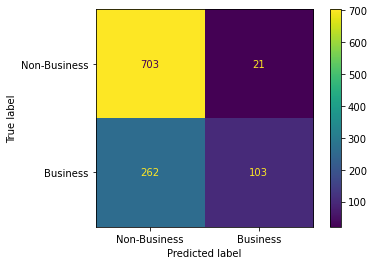

In [529]:
#confusion matrix 
cm = confusion_matrix(target_test, predicted, labels=[0,1])
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

precision score: The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
recall scores: The recall is intuitively the ability of the classifier to find all the positive samples.

In [530]:
print("Precision (Business) = %.4f" % precision_score(target_test, predicted, pos_label=1) )
print("Recall (Business) = %.4f" % recall_score(target_test, predicted, pos_label=1) )

Precision (Business) = 0.8306
Recall (Business) = 0.2822


In [531]:
#F1-score, is a measure of a model's accuracy on a dataset
print("F1 (Business) = %.4f" % f1_score(target_test, predicted, pos_label=1) )
print("F1 (Non-Business) = %.4f" % f1_score(target_test, predicted, pos_label=0) )

F1 (Business) = 0.4213
F1 (Non-Business) = 0.8324


The *classification_report()* functions provides a convenient way of summarising all of this information. 
*support* here indicates the number of actual occurrences of a class in the test data.

In [532]:
 print(classification_report(target_test, predicted, target_names=target_categories))

              precision    recall  f1-score   support

Non-Business       0.73      0.97      0.83       724
    Business       0.83      0.28      0.42       365

    accuracy                           0.74      1089
   macro avg       0.78      0.63      0.63      1089
weighted avg       0.76      0.74      0.69      1089



# Binary classifer - 2 
1.Sport or non sport stories(A,B) 0 = Non-sport, 1 = Sport

In [537]:
import numpy as np
df['Sport'] = np.where(df['Category']== 'Sport', 1,0) # Sport stories is set to 1
df.head(5)

,Category,Title,Snippet,Label,Business,Sport
0,Business,Zero-carbon electricity outstrips fossil fuels...,Summary: Zero-carbon energy became Britain’s l...,0,1,0
1,Sport,Twenty athletes set to light up the Tokyo 2020...,"Dina Asher-Smith Great Britain Athletics, 100m...",1,0,1
2,Business,"US election, Brexit and China to sway the mark...","After profiting from strong markets in 2019, i...",0,1,0
3,Politics,Clive Lewis calls for unity among Labour leade...,Summary: The Labour leadership hopeful Clive L...,2,0,0
4,Sport,Michael van Gerwen 3-7 Peter Wright: PDC world...,"Summary: That’s it for tonight’s blog, so I’ll...",1,0,1


In [538]:
target_categories_2 = ["Non-Sport", "Sport"]
my_target_2 = df["Sport"]
my_documents_2 = df['Snippet']

In [539]:
vectorizer = CountVectorizer(min_df = 10, stop_words=None)
X = vectorizer.fit_transform(my_documents_2)
print(X.shape)

(5444, 1781)


In [540]:
## Classification and Evaluation 
data_train, data_test, target_train, target_test = train_test_split(X, my_target_2, test_size=0.3)

In [541]:
print("Training set has %d examples" % data_train.shape[0] )
print("Test set has %d examples" % data_test.shape[0] )

Training set has 3810 examples
Test set has 1634 examples


In [542]:
model = KNeighborsClassifier(n_neighbors=3) # Building our KNN model(nearest to 3)
model.fit(data_train, target_train) # fiiting our data to the model we have created.

KNeighborsClassifier(n_neighbors=3)

In [543]:
predicted = model.predict(data_test) # our model results
predicted

array([1, 0, 0, ..., 0, 1, 0])

In [544]:
print("Accuracy = %.4f" % accuracy_score(target_test, predicted))
# The ouput shows 69% of accuracy when we test the our model.

Accuracy = 0.6946


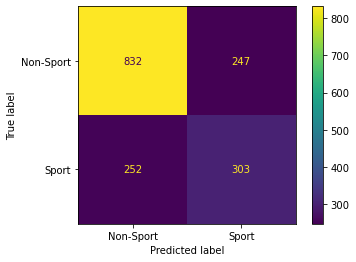

In [545]:
cm = confusion_matrix(target_test, predicted, labels=[0,1])
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories_2)
cmd.plot();

In [546]:
print("F1 (Sport) = %.4f" % f1_score(target_test, predicted, pos_label=1) )
print("F1 (Non-Sport) = %.4f" % f1_score(target_test, predicted, pos_label=0) )

F1 (Sport) = 0.5484
F1 (Non-Sport) = 0.7693


In [547]:
print("Precision (Sport) = %.4f" % precision_score(target_test, predicted, pos_label=1) )
print("Recall (Sport) = %.4f" % recall_score(target_test, predicted, pos_label=1) )

Precision (Sport) = 0.5509
Recall (Sport) = 0.5459


In [548]:
print("Precision (Non-Sport) = %.4f" % precision_score(target_test, predicted, pos_label=0) )
print("Recall (Non-Sport) = %.4f" % recall_score(target_test, predicted, pos_label=0) )

Precision (Non-Sport) = 0.7675
Recall (Non-Sport) = 0.7711


In [549]:
print(classification_report(target_test, predicted, target_names=target_categories_2))

              precision    recall  f1-score   support

   Non-Sport       0.77      0.77      0.77      1079
       Sport       0.55      0.55      0.55       555

    accuracy                           0.69      1634
   macro avg       0.66      0.66      0.66      1634
weighted avg       0.69      0.69      0.69      1634



# Binary classifer - 3
1.Sport or non sport stories(A,B) 0 = Non-Politics, 1 = Politics

In [551]:
import numpy as np
df['Politics'] = np.where(df['Category']== 'Politics', 1,0) # Politics stories is set to 1
df.head(5)

,Category,Title,Snippet,Label,Business,Sport,Politics
0,Business,Zero-carbon electricity outstrips fossil fuels...,Summary: Zero-carbon energy became Britain’s l...,0,1,0,0
1,Sport,Twenty athletes set to light up the Tokyo 2020...,"Dina Asher-Smith Great Britain Athletics, 100m...",1,0,1,0
2,Business,"US election, Brexit and China to sway the mark...","After profiting from strong markets in 2019, i...",0,1,0,0
3,Politics,Clive Lewis calls for unity among Labour leade...,Summary: The Labour leadership hopeful Clive L...,2,0,0,1
4,Sport,Michael van Gerwen 3-7 Peter Wright: PDC world...,"Summary: That’s it for tonight’s blog, so I’ll...",1,0,1,0


In [552]:
target_categories_3 = ["Non-Politics", "Politics"]
my_target_3 = df["Politics"]
my_documents_3 = df['Snippet']

In [553]:
vectorizer = CountVectorizer(min_df = 10, stop_words=None)
X = vectorizer.fit_transform(my_documents_3)
print(X.shape)

(5444, 1781)


In [554]:
## Classification and Evaluation 
data_train_3, data_test_3, target_train_3, target_test_3 = train_test_split(X, my_target_3, test_size=0.2)
#test data being 20%

In [555]:
print("Training set has %d examples" % data_train_3.shape[0] )
print("Test set has %d examples" % data_test_3.shape[0] )

Training set has 4355 examples
Test set has 1089 examples


In [556]:
model = KNeighborsClassifier(n_neighbors=3) # Building our KNN model(nearest to 3)
model.fit(data_train_3, target_train_3) # fiiting our data to the model we have created.

KNeighborsClassifier(n_neighbors=3)

In [557]:
predicted = model.predict(data_test_3) # our model results
predicted

array([1, 0, 0, ..., 0, 0, 0])

In [560]:
print("Accuracy = %.4f" % accuracy_score(target_test_3, predicted))
# The ouput shows 71% of accuracy when we test the our model.

Accuracy = 0.7199


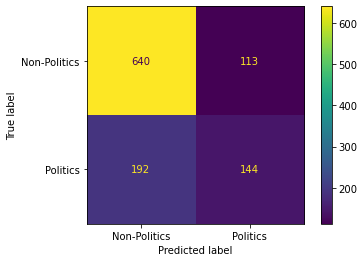

In [561]:
cm = confusion_matrix(target_test_3, predicted, labels=[0,1])
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories_3)
cmd.plot();

In [562]:
print("F1 (Politics) = %.4f" % f1_score(target_test_3, predicted, pos_label=1) )
print("F1 (Non-Politics) = %.4f" % f1_score(target_test_3, predicted, pos_label=0) )

F1 (Politics) = 0.4857
F1 (Non-Politics) = 0.8076


In [563]:
print("Precision (Politics) = %.4f" % precision_score(target_test_3, predicted, pos_label=1) )
print("Recall (Politics) = %.4f" % recall_score(target_test_3, predicted, pos_label=1) )

Precision (Politics) = 0.5603
Recall (Politics) = 0.4286


In [564]:
print("Precision (Non-Politics) = %.4f" % precision_score(target_test_3, predicted, pos_label=0) )
print("Recall (Non-Politics) = %.4f" % recall_score(target_test_3, predicted, pos_label=0) )

Precision (Non-Politics) = 0.7692
Recall (Non-Politics) = 0.8499


In [565]:
print(classification_report(target_test_3, predicted, target_names=target_categories_3))

              precision    recall  f1-score   support

Non-Politics       0.77      0.85      0.81       753
    Politics       0.56      0.43      0.49       336

    accuracy                           0.72      1089
   macro avg       0.66      0.64      0.65      1089
weighted avg       0.70      0.72      0.71      1089



# Task 3. Multi-Class Text Classification

1.Using all three categories (A,B,C) that you have selected:
-Apply appropriate preprocessing steps to create a numeric representation of the documents for these three categories, suitable for classification.
-Train a classification model using a multi-class classifier of your choice, which can distinguish documents from the categories A, B, and C.
-Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results.

In [566]:
my_documents_4 = df['Title']
my_target_4 = df['Label']

In [567]:
vectorizer = CountVectorizer(min_df = 10, stop_words=None)
X = vectorizer.fit_transform(my_documents_4)
print(X.shape)

(5444, 1026)


In [568]:
## Classification and Evaluation 
data_train_4, data_test_4, target_train_4, target_test_4 = train_test_split(X, my_target_4, test_size=0.3)
#test data being 30%

In [569]:
print("Training set has %d examples" % data_train_4.shape[0] )
print("Test set has %d examples" % data_test_4.shape[0] )

Training set has 3810 examples
Test set has 1634 examples


In [570]:
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(data_train_4, target_train_4)
dtree_predictions = dtree_model.predict(data_test_4)

In [571]:
print("Accuracy = %.5f" % accuracy_score(target_test_4, dtree_predictions))

Accuracy = 0.41432


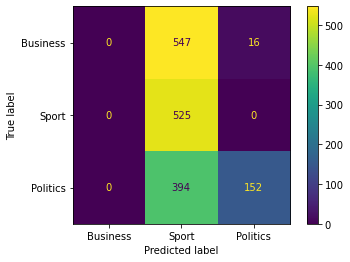

In [572]:
target_categories_4 = ["Business","Sport","Politics"]
# creating a confusion matrix
cm = confusion_matrix(target_test_4, dtree_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories_4)
cmd.plot();

In [576]:
print(classification_report(target_test_4, dtree_predictions,target_names=target_categories_4))

              precision    recall  f1-score   support

    Business       0.00      0.00      0.00       563
       Sport       0.36      1.00      0.53       525
    Politics       0.90      0.28      0.43       546

    accuracy                           0.41      1634
   macro avg       0.42      0.43      0.32      1634
weighted avg       0.42      0.41      0.31      1634

